In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from misc_scripts.fun_factor_update import *
from pycmqlib3.strategy.signal_repo import signal_store, custom_funda_signal

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [5]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


In [6]:
from bktest.backtest_grid_search import *

tday = datetime.date.today()
roll_name = 'hot'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=tday,
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d',
    shift_mode=2
)

if len(error_list) > 0:
    print(error_list)

spot_df = get_fun_data(datetime.date(2008,1,1), tday)    
print(spot_df)

index_code  rebar_gz  rebar_sh  rebar_sy  hrc_bj  hrc_gz  hrc_sh  crc_bj  \
date                                                                       
2008-01-01       NaN       NaN       NaN     NaN     NaN     NaN     NaN   
2008-01-02    4850.0    4490.0    4490.0  4600.0  4830.0  4750.0     NaN   
2008-01-03    4850.0    4500.0    4490.0  4630.0  4830.0  4750.0     NaN   
2008-01-04    4880.0    4500.0    4490.0  4630.0  4830.0  4750.0     NaN   
2008-01-05       NaN       NaN       NaN     NaN     NaN     NaN     NaN   
...              ...       ...       ...     ...     ...     ...     ...   
2023-06-25    3830.0    3720.0    3780.0  3880.0  3780.0  3840.0  4440.0   
2023-06-26    3790.0    3690.0    3740.0  3850.0  3770.0  3820.0  4440.0   
2023-06-27    3830.0    3750.0    3780.0  3880.0  3840.0  3880.0  4470.0   
2023-06-28    3830.0    3760.0    3780.0  3880.0  3820.0  3870.0  4500.0   
2023-06-29       NaN       NaN       NaN     NaN     NaN     NaN     NaN   

index_code 

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


In [7]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.155, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0945, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0758, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0595, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0484, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.151, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.0844, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.22, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.502, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.420, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.527, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.163, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.147, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.143, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0406, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0381, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.0369, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.119, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.117, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.122, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.120, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.125, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.137, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.456, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),    
]

scenarios_test2 = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.1666, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.3989, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('funda_ferrous', 'io_millinv_lyoy', 0.4, 1, 1, 1, (None, {}, ''), None),
    #('funda_ferrous', 'io_millinv_lvl', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'io_removal_lyoy', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'io_removal_lvl', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'io_invdays_lyoy', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'io_invdays_lvl', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'strip_hsec_lvl_mid', 0.4, 1, 1, 1, (None, {}, ''), None),
    ('funda_ferrous', 'steel_margin_lvl_fast', 0.4, 1, 1, 1, (None, {}, ''), None),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 1.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 1.0, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.0, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 1.0, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 1.0, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 1.0, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('custom', 'hc_rb_diff', 1.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'leader_lagger', 0.4, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [8]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

In [10]:
#holdings.keys()

dict_keys([])

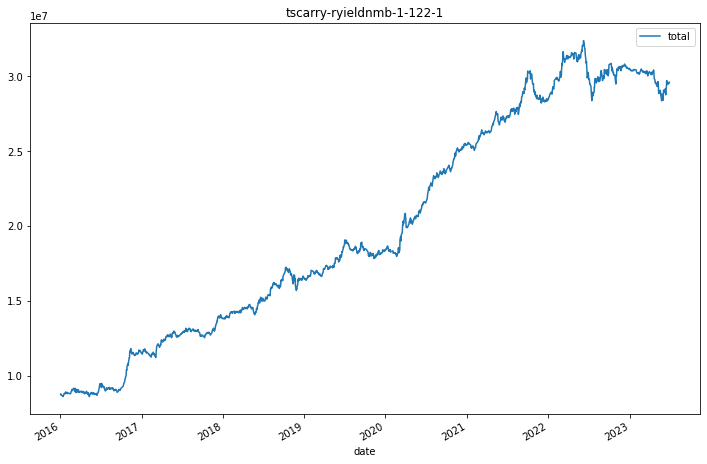

       sharpe        std  sortino
tenor                            
all      1.58   96437.57     2.27
6m      -0.88  135484.08    -1.32
1y      -0.18  155563.62    -0.30
2y       0.47  161150.82     0.75
3y       1.20  142678.86     1.86
4y       1.30  136570.33     2.02
5y       1.44  130454.64     2.24
6y       1.47  122513.34     2.25
7y       1.58  117740.55     2.43
8y       1.52  114127.11     2.30
9y       1.52  109669.37     2.30
10y      1.56  105393.03     2.33
11y      1.63  102012.70     2.42


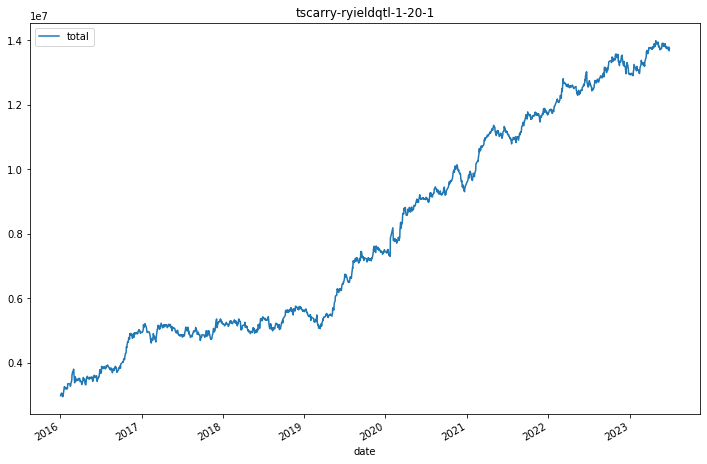

       sharpe       std  sortino
tenor                           
all      1.37  51642.79     2.15
6m       1.73  57397.67     2.84
1y       1.18  62596.60     1.94
2y       1.35  60940.99     2.13
3y       1.69  59132.30     2.72
4y       1.84  63242.22     3.20
5y       1.76  61281.17     3.05
6y       1.57  60366.61     2.68
7y       1.56  59061.06     2.66
8y       1.42  58932.60     2.36
9y       1.41  57476.11     2.34
10y      1.46  55731.69     2.38
11y      1.47  54002.93     2.39


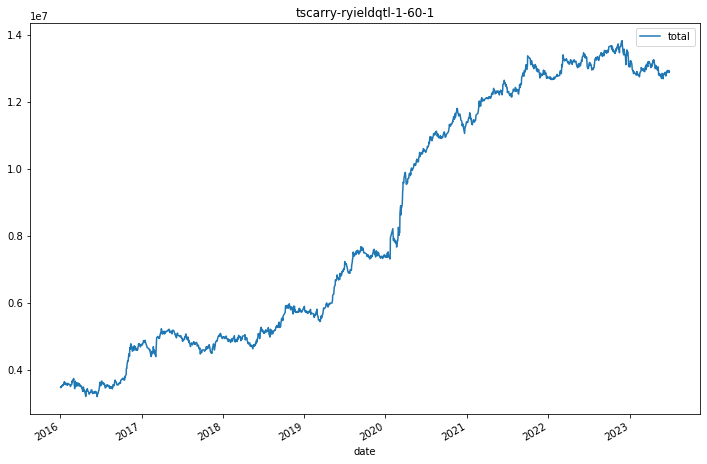

       sharpe       std  sortino
tenor                           
all      1.28  51997.27     1.99
6m      -0.37  58906.55    -0.66
1y      -0.09  64268.97    -0.14
2y       0.22  62121.70     0.37
3y       0.86  58852.22     1.43
4y       1.43  66576.92     2.53
5y       1.55  64215.90     2.70
6y       1.37  61960.78     2.32
7y       1.42  60643.99     2.41
8y       1.25  59417.38     2.05
9y       1.21  57986.13     1.98
10y      1.32  56177.58     2.14
11y      1.36  54356.27     2.19


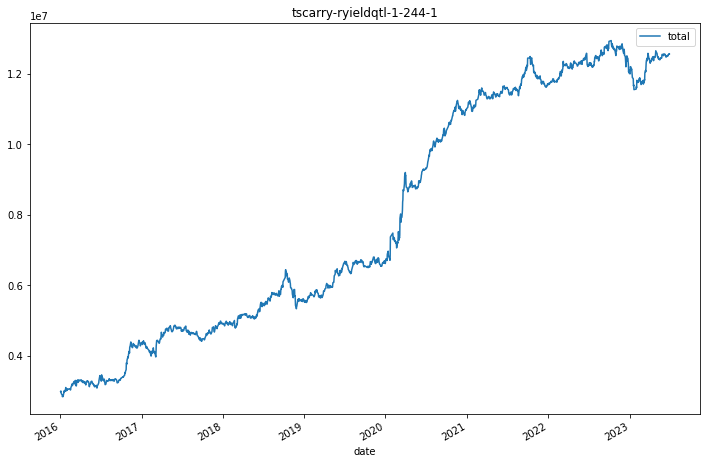

       sharpe       std  sortino
tenor                           
all      1.39  46571.32     2.01
6m       1.06  63276.20     1.67
1y       0.35  65072.73     0.54
2y       0.51  60176.33     0.78
3y       1.24  56595.87     1.90
4y       1.53  62747.16     2.46
5y       1.52  60669.54     2.40
6y       1.45  57681.25     2.27
7y       1.50  56121.07     2.38
8y       1.41  54981.08     2.18
9y       1.37  53129.23     2.12
10y      1.37  51049.69     2.09
11y      1.45  49305.62     2.20


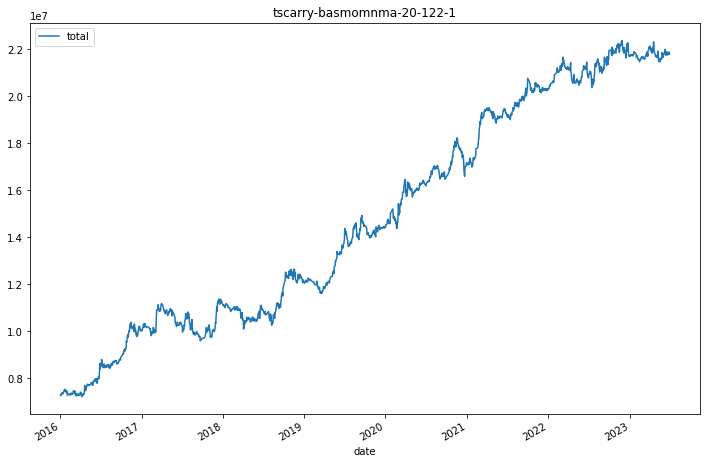

       sharpe        std  sortino
tenor                            
all      1.25   90167.49     1.81
6m       0.13   86627.10     0.20
1y       0.55  114815.47     0.95
2y       0.77  106899.72     1.27
3y       1.16  102973.52     1.88
4y       1.22  106911.44     1.92
5y       1.34  104806.24     2.13
6y       1.18  104403.28     1.82
7y       1.21  102077.25     1.89
8y       1.09  104727.94     1.67
9y       1.09  101429.87     1.66
10y      1.24   97531.28     1.87
11y      1.30   94441.16     1.94


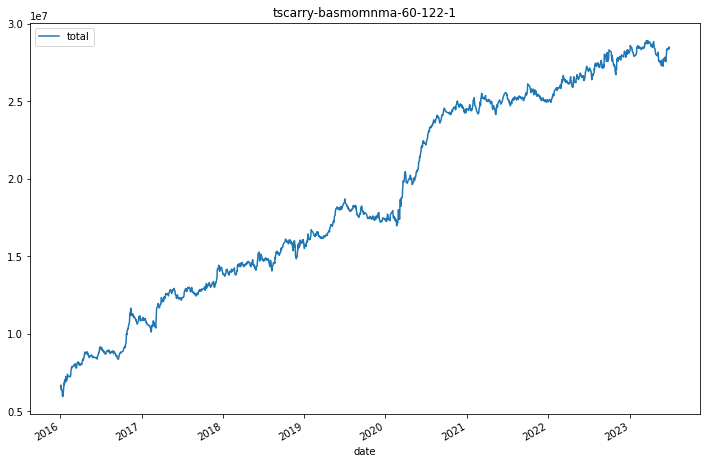

       sharpe        std  sortino
tenor                            
all      1.29  114060.80     1.94
6m       0.39  120342.17     0.74
1y       0.62  149054.58     1.19
2y       0.71  133467.63     1.30
3y       1.05  126089.00     1.85
4y       1.22  132577.64     2.13
5y       1.34  131891.44     2.21
6y       1.36  128028.83     2.19
7y       1.42  125848.31     2.32
8y       1.31  131644.25     2.09
9y       1.30  127809.48     2.05
10y      1.29  123216.22     2.03
11y      1.38  120059.00     2.15


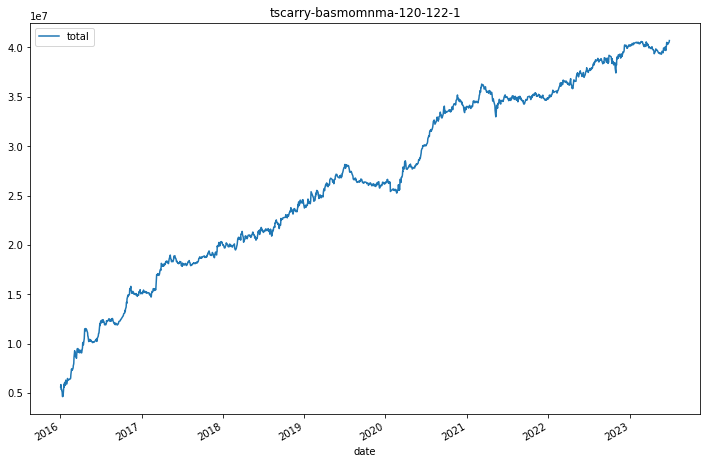

       sharpe        std  sortino
tenor                            
all      1.43  146894.55     2.10
6m       0.55  109545.90     0.95
1y       1.26  159725.84     2.09
2y       1.23  150129.46     2.08
3y       1.42  159307.80     2.22
4y       1.32  158100.36     1.99
5y       1.54  161640.02     2.35
6y       1.52  158692.32     2.33
7y       1.69  156838.68     2.65
8y       1.63  170244.06     2.55
9y       1.51  166053.29     2.36
10y      1.47  159375.70     2.27
11y      1.53  155498.41     2.35


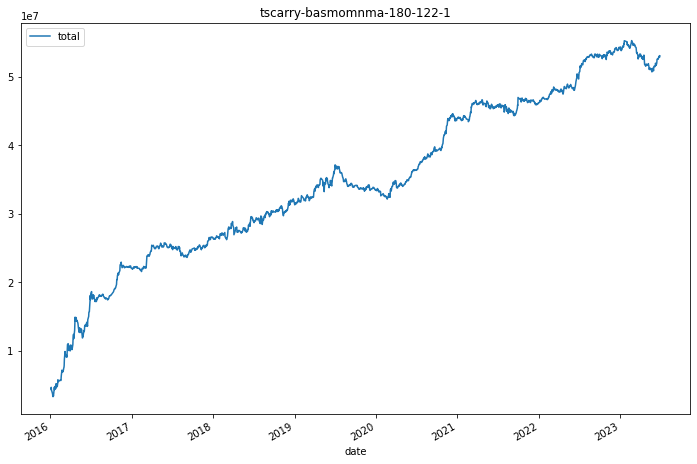

       sharpe        std  sortino
tenor                            
all      1.34  204747.87     1.94
6m      -0.71  226209.92    -1.20
1y       0.94  208931.92     1.54
2y       1.14  208698.09     2.02
3y       1.75  203599.23     3.01
4y       1.40  198405.25     2.32
5y       1.46  210330.15     2.39
6y       1.41  211439.70     2.25
7y       1.57  208975.08     2.53
8y       1.48  241320.77     2.33
9y       1.49  234149.72     2.33
10y      1.50  224752.68     2.32
11y      1.46  217319.41     2.23


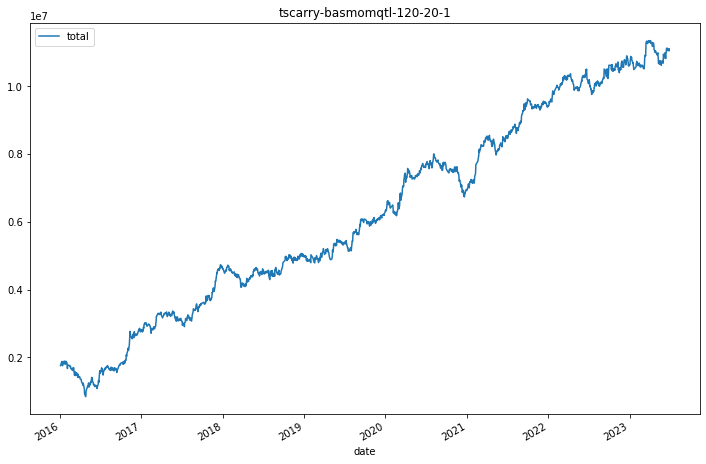

       sharpe       std  sortino
tenor                           
all      1.15  49573.84     1.76
6m       0.97  67112.78     1.67
1y       0.82  71442.97     1.32
2y       1.30  63238.76     2.10
3y       1.20  61585.85     1.94
4y       1.49  61790.12     2.42
5y       1.40  60577.48     2.33
6y       1.44  58955.10     2.39
7y       1.53  57482.34     2.52
8y       1.28  57466.74     2.11
9y       1.18  55714.94     1.92
10y      1.22  53899.56     1.97
11y      1.22  52217.71     1.95


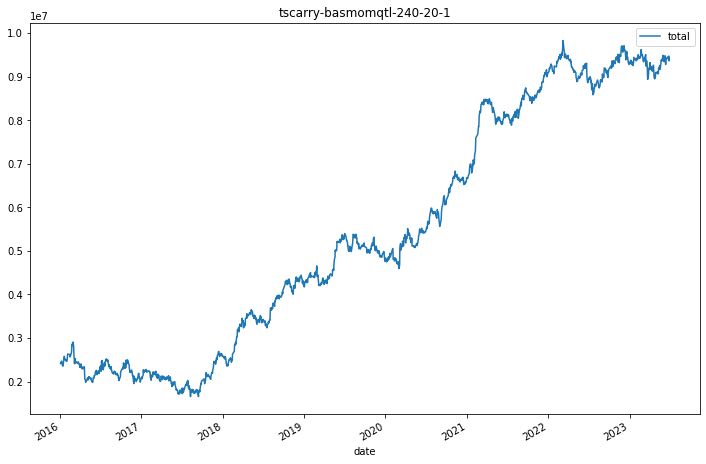

       sharpe       std  sortino
tenor                           
all      1.03  46998.69     1.48
6m       0.22  67258.70     0.31
1y       0.54  66082.12     0.82
2y       0.68  60851.75     1.00
3y       1.44  59480.30     2.19
4y       1.11  59596.13     1.74
5y       1.34  57747.84     2.11
6y       1.46  56409.47     2.29
7y       1.19  55234.72     1.89
8y       1.03  55081.27     1.58
9y       1.08  53248.35     1.65
10y      1.07  51477.39     1.63
11y      1.12  49785.39     1.68


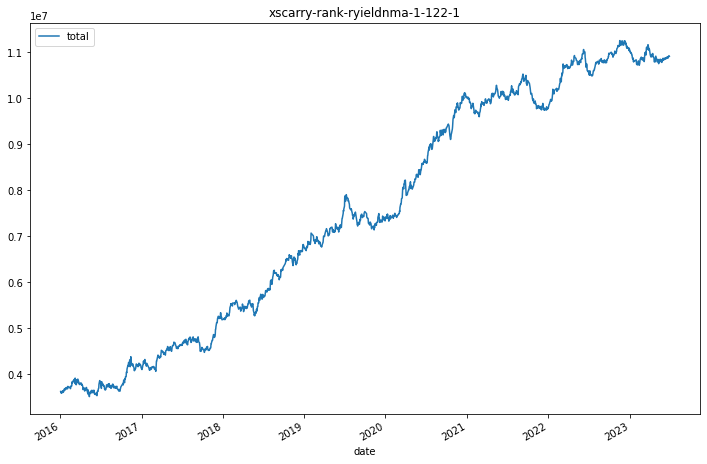

       sharpe       std  sortino
tenor                           
all      1.62  36193.32     2.54
6m      -0.57  39446.70    -0.89
1y       0.59  36023.49     0.91
2y       0.73  40740.29     1.08
3y       1.13  42513.85     1.81
4y       1.25  43479.76     2.02
5y       1.57  43198.25     2.63
6y       1.58  42378.52     2.63
7y       1.55  41876.37     2.59
8y       1.56  41192.10     2.60
9y       1.50  40018.84     2.47
10y      1.59  38950.41     2.60
11y      1.66  37568.68     2.67


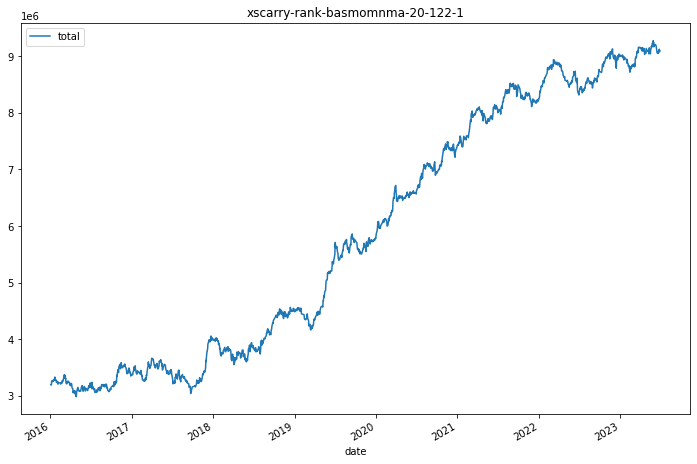

       sharpe       std  sortino
tenor                           
all      1.54  31942.94     2.38
6m       0.22  36204.75     0.42
1y       1.34  35886.75     2.35
2y       0.87  36556.82     1.38
3y       1.44  37431.59     2.30
4y       1.57  37705.37     2.54
5y       1.82  37164.64     2.94
6y       1.61  37511.35     2.58
7y       1.46  37016.34     2.35
8y       1.43  36117.50     2.29
9y       1.32  35147.65     2.11
10y      1.45  34131.08     2.31
11y      1.50  32922.60     2.34


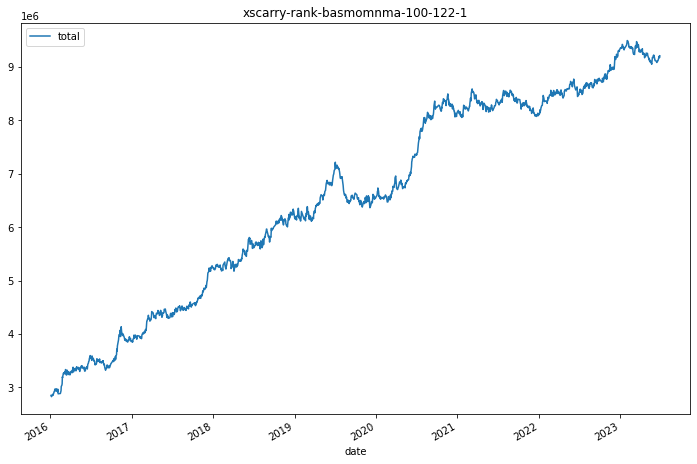

       sharpe       std  sortino
tenor                           
all      1.58  32507.99     2.50
6m      -0.42  31887.12    -0.67
1y       1.35  35252.52     2.36
2y       0.75  35057.70     1.26
3y       1.06  37285.00     1.76
4y       0.94  37229.58     1.56
5y       1.20  38489.22     1.97
6y       1.37  37946.74     2.21
7y       1.38  37457.92     2.28
8y       1.51  36784.51     2.50
9y       1.56  35494.42     2.55
10y      1.54  34363.12     2.51
11y      1.60  33186.10     2.57


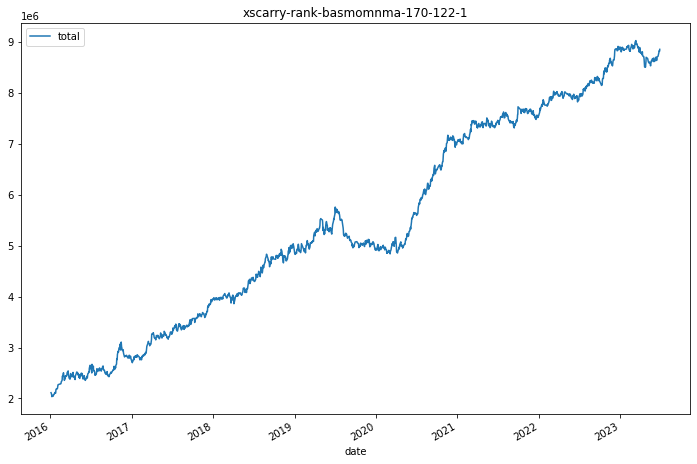

       sharpe       std  sortino
tenor                           
all      1.60  31618.94     2.53
6m      -0.14  34458.03    -0.23
1y       1.80  35289.01     3.05
2y       1.36  33818.76     2.39
3y       1.93  35561.69     3.32
4y       1.51  35537.22     2.55
5y       1.55  37490.17     2.56
6y       1.63  36352.30     2.65
7y       1.58  36097.31     2.59
8y       1.61  35279.77     2.62
9y       1.64  34087.77     2.65
10y      1.68  33136.65     2.70
11y      1.63  31944.78     2.60


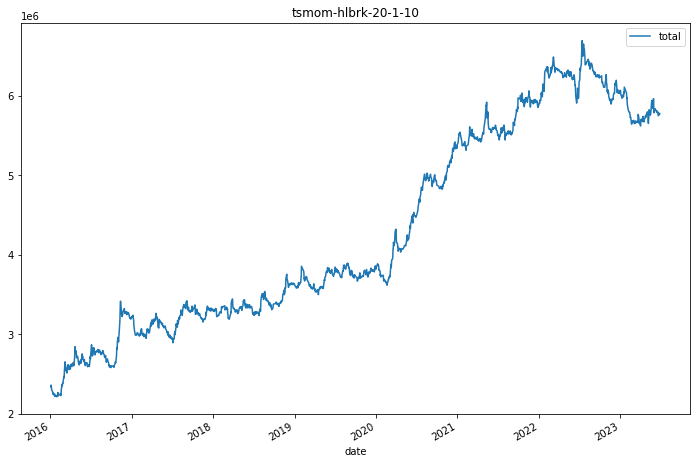

       sharpe       std  sortino
tenor                           
all      1.01  29425.73     1.46
6m      -0.95  36341.18    -1.27
1y      -0.42  40245.00    -0.55
2y       0.17  38686.44     0.26
3y       0.75  36707.98     1.08
4y       0.93  34935.42     1.35
5y       0.97  33304.38     1.42
6y       0.94  32431.94     1.37
7y       0.88  32300.69     1.32
8y       1.00  33047.04     1.47
9y       1.02  32245.54     1.50
10y      1.02  31211.83     1.50
11y      1.04  30413.56     1.52


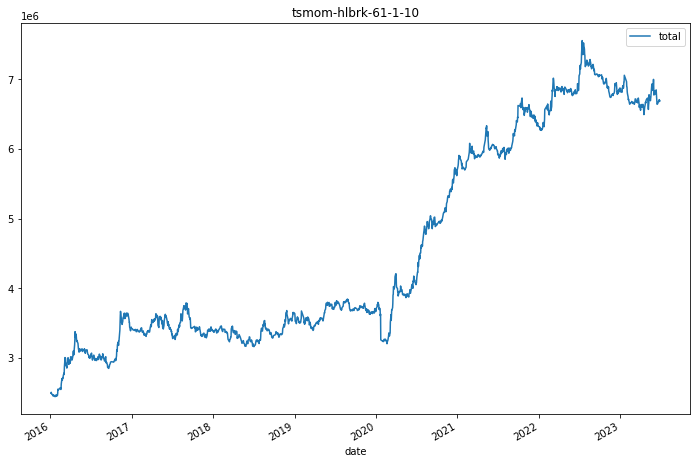

       sharpe       std  sortino
tenor                           
all      1.04  33138.34     1.44
6m      -0.49  44469.04    -0.64
1y      -0.31  44065.14    -0.41
2y       0.52  42640.05     0.78
3y       1.34  41561.00     2.01
4y       1.16  41391.65     1.55
5y       1.16  38933.96     1.57
6y       0.95  37346.98     1.31
7y       0.92  36748.88     1.29
8y       1.06  37483.49     1.49
9y       1.09  36425.25     1.53
10y      1.08  35141.00     1.51
11y      1.07  34278.10     1.50


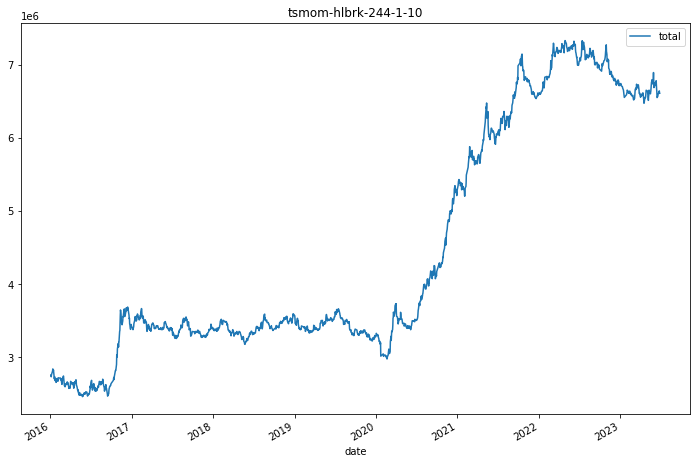

       sharpe       std  sortino
tenor                           
all      1.08  31684.26     1.47
6m      -0.40  35793.59    -0.56
1y      -0.68  36259.04    -0.94
2y       0.45  39518.69     0.68
3y       1.57  42235.75     2.35
4y       1.25  39694.67     1.83
5y       1.15  36863.84     1.66
6y       0.99  34778.32     1.42
7y       1.06  34894.65     1.56
8y       1.07  36367.26     1.55
9y       1.13  35450.75     1.63
10y      1.15  34311.97     1.66
11y      1.14  33455.30     1.62


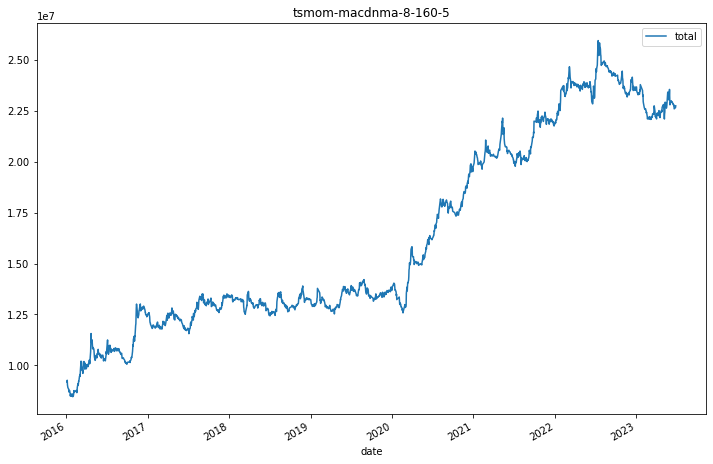

       sharpe        std  sortino
tenor                            
all      1.03  113589.44     1.47
6m      -0.68  156169.72    -0.87
1y      -0.28  161417.98    -0.36
2y       0.52  156251.49     0.76
3y       0.94  149223.20     1.34
4y       1.04  141452.90     1.52
5y       0.98  133533.43     1.44
6y       0.91  129548.94     1.34
7y       0.88  127854.93     1.32
8y       0.96  130700.06     1.43
9y       0.96  126078.99     1.41
10y      0.95  121387.09     1.39
11y      0.97  118410.89     1.41


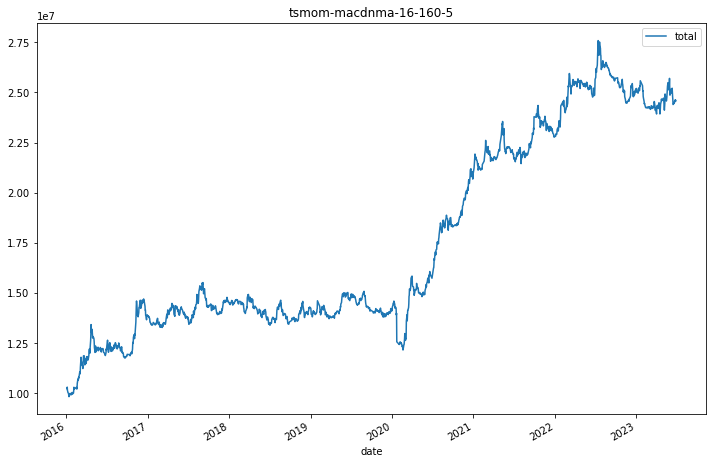

       sharpe        std  sortino
tenor                            
all      1.02  124705.76     1.38
6m      -0.37  166976.16    -0.51
1y      -0.18  167267.72    -0.25
2y       0.50  164081.95     0.75
3y       1.18  159137.44     1.72
4y       1.01  158230.37     1.34
5y       0.97  147993.24     1.30
6y       0.81  142749.88     1.11
7y       0.82  140959.29     1.14
8y       0.96  144116.56     1.35
9y       0.98  138637.74     1.37
10y      0.99  133235.85     1.37
11y      0.97  130061.81     1.35


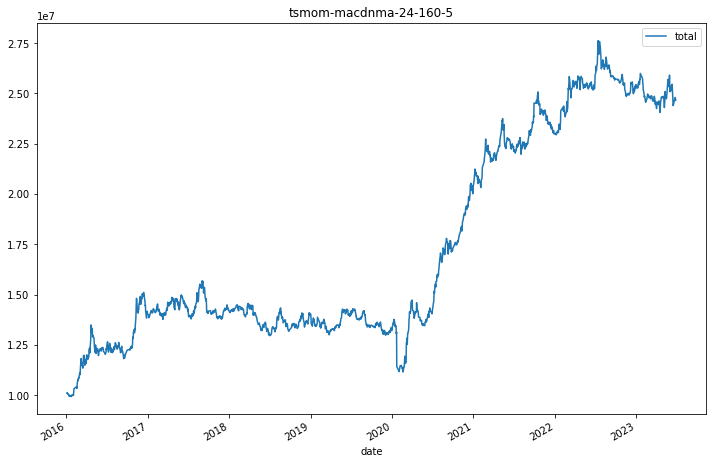

       sharpe        std  sortino
tenor                            
all      0.98  129245.05     1.30
6m      -0.53  170199.19    -0.73
1y      -0.28  166914.68    -0.38
2y       0.43  165813.26     0.63
3y       1.36  164834.00     2.03
4y       1.04  165755.65     1.33
5y       0.97  154475.40     1.25
6y       0.75  147943.35     0.98
7y       0.79  146238.74     1.05
8y       0.94  149336.52     1.28
9y       0.99  143801.73     1.35
10y      1.00  138175.93     1.35
11y      0.97  134824.40     1.31


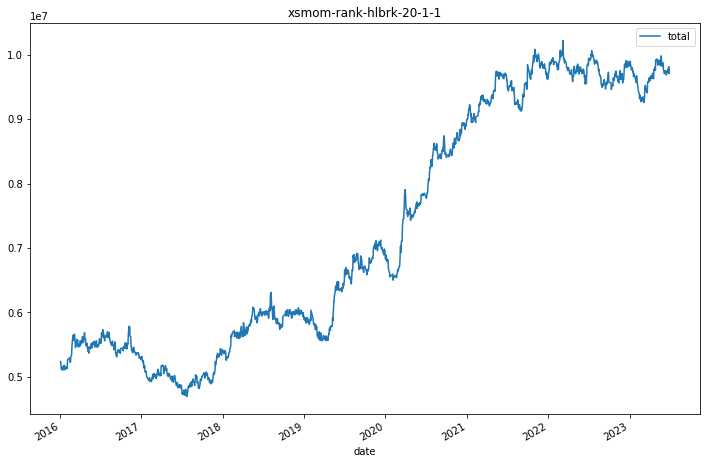

       sharpe       std  sortino
tenor                           
all      1.23  41284.23     1.97
6m      -0.21  48149.80    -0.37
1y      -0.12  45998.66    -0.19
2y       0.05  50840.95     0.08
3y       0.83  49662.03     1.37
4y       1.06  51004.28     1.78
5y       0.96  50534.85     1.63
6y       1.07  49438.93     1.79
7y       0.80  48107.76     1.33
8y       0.91  46925.07     1.52
9y       1.01  45952.19     1.68
10y      1.13  44599.71     1.87
11y      1.18  43168.72     1.93


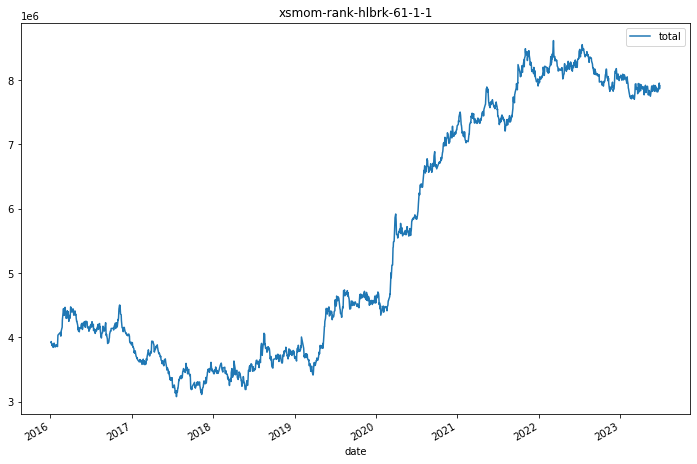

       sharpe       std  sortino
tenor                           
all      0.99  42088.43     1.55
6m      -0.35  45909.07    -0.56
1y      -0.60  44286.13    -0.92
2y       0.18  50880.88     0.29
3y       0.85  50352.94     1.41
4y       1.12  51391.29     1.89
5y       1.12  50816.26     1.87
6y       0.98  49964.43     1.61
7y       0.72  48504.11     1.17
8y       0.74  47289.20     1.21
9y       0.80  46339.10     1.29
10y      0.90  45064.07     1.44
11y      0.97  43679.33     1.54


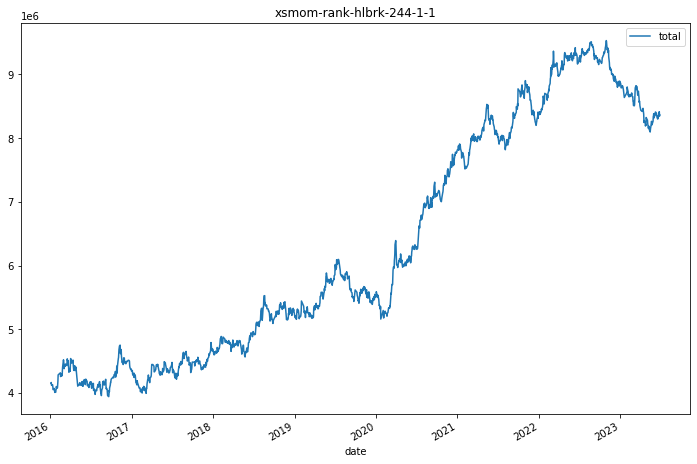

       sharpe       std  sortino
tenor                           
all      1.16  40457.86     1.77
6m      -1.50  42633.69    -2.48
1y      -1.35  39196.84    -2.10
2y       0.17  48024.57     0.27
3y       0.90  48386.71     1.48
4y       0.86  48566.46     1.40
5y       0.94  47595.75     1.53
6y       0.91  46238.82     1.45
7y       0.85  45584.57     1.34
8y       0.83  44830.48     1.31
9y       0.93  43711.55     1.47
10y      1.05  42316.33     1.63
11y      1.10  41043.51     1.68


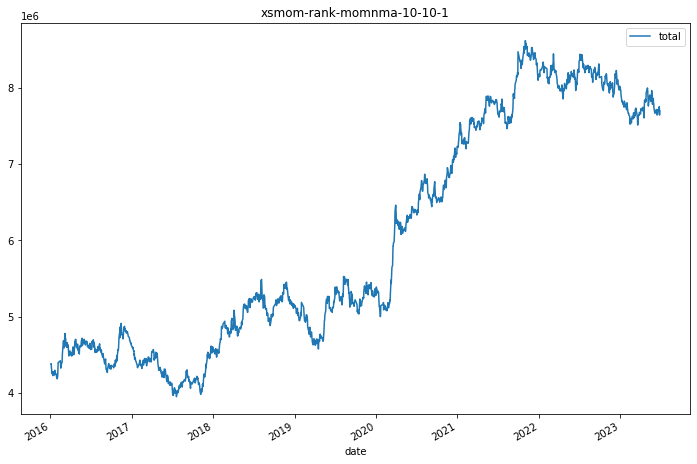

       sharpe       std  sortino
tenor                           
all      0.97  41130.70     1.55
6m      -0.83  47859.93    -1.21
1y      -0.73  47398.00    -1.07
2y      -0.09  51066.14    -0.14
3y       0.55  49920.16     0.88
4y       0.80  50745.68     1.31
5y       0.64  49945.28     1.07
6y       0.79  48905.99     1.30
7y       0.59  47594.93     0.98
8y       0.71  46669.24     1.18
9y       0.84  45699.50     1.40
10y      0.94  44267.83     1.54
11y      0.97  42883.22     1.57


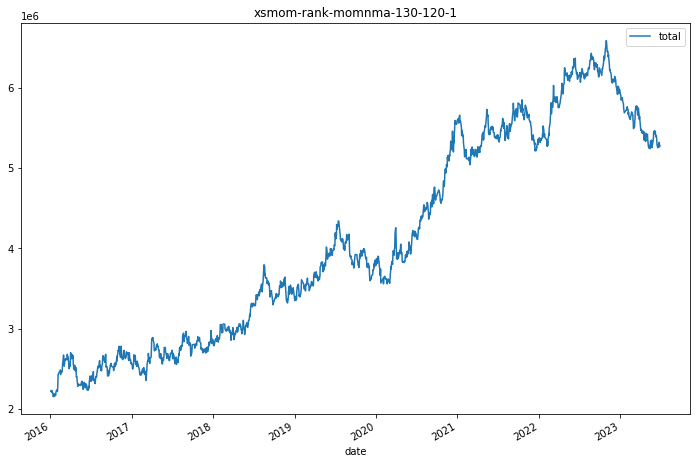

       sharpe       std  sortino
tenor                           
all      0.77  38639.36     1.16
6m      -2.27  40501.60    -3.83
1y      -1.41  39327.96    -2.34
2y      -0.08  45456.87    -0.13
3y       0.49  46488.94     0.79
4y       0.44  46504.32     0.70
5y       0.57  45354.45     0.90
6y       0.63  44209.38     0.98
7y       0.60  43673.41     0.95
8y       0.60  42953.34     0.95
9y       0.65  41667.62     1.02
10y      0.71  40321.73     1.10
11y      0.73  39166.23     1.11


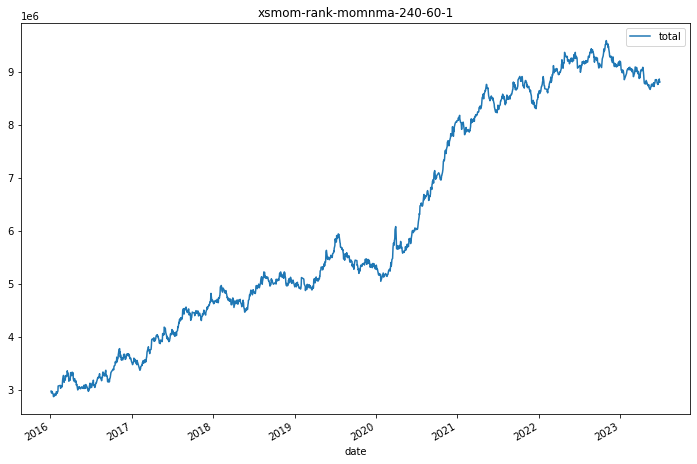

       sharpe       std  sortino
tenor                           
all      1.35  37236.46     2.12
6m      -1.13  39707.08    -1.76
1y      -0.47  38739.83    -0.73
2y       0.41  41584.71     0.63
3y       1.38  42707.75     2.23
4y       1.18  43631.21     1.87
5y       1.20  42720.11     1.94
6y       1.21  42113.03     1.95
7y       1.25  41485.28     2.03
8y       1.23  40871.59     2.00
9y       1.25  39699.03     2.00
10y      1.29  38419.12     2.05
11y      1.32  37442.17     2.07


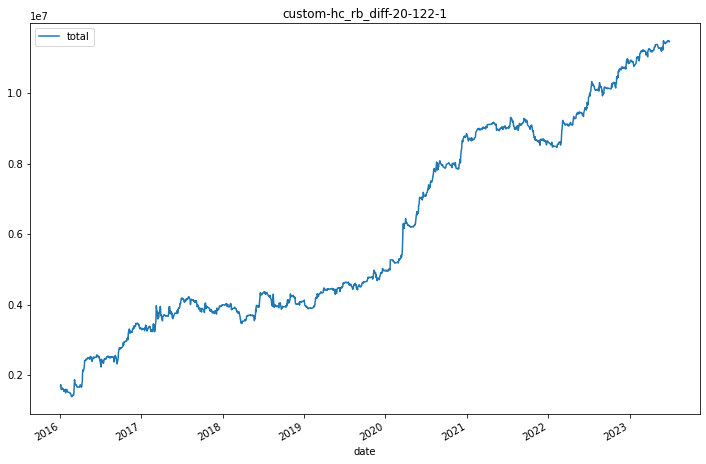

       sharpe       std  sortino
tenor                           
all      1.68  48673.04     2.69
6m       1.98  40788.79     3.63
1y       2.27  49512.48     3.96
2y       1.67  47580.69     3.04
3y       2.01  46486.17     3.53
4y       2.27  48574.59     4.09
5y       1.92  47878.82     3.16
6y       1.67  47091.26     2.74
7y       1.68  49207.78     2.67
8y       1.69  50050.10     2.76
9y       1.68  48673.04     2.69
10y      1.68  48673.04     2.69
11y      1.68  48673.04     2.69


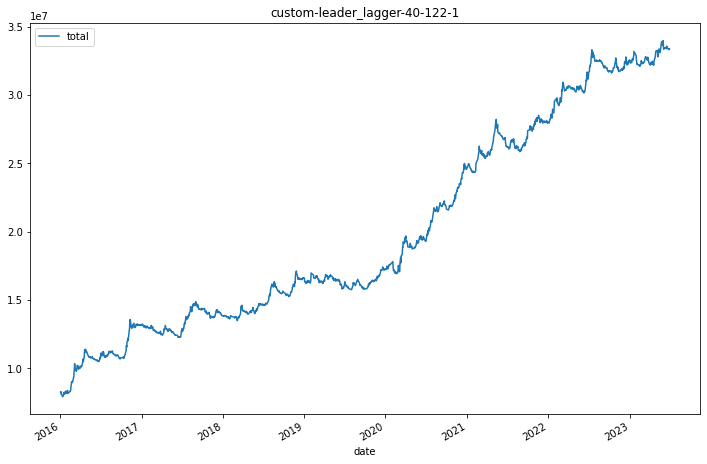

       sharpe        std  sortino
tenor                            
all      1.65  104079.77     2.37
6m       0.86  131330.76     1.16
1y       0.96  133144.39     1.29
2y       1.63  140593.81     2.51
3y       2.13  140536.61     3.30
4y       2.07  135848.19     3.12
5y       1.86  129381.45     2.84
6y       1.80  123992.95     2.75
7y       1.73  120326.92     2.65
8y       1.84  123513.38     2.78
9y       1.78  118712.78     2.66
10y      1.76  114329.32     2.60
11y      1.73  109897.29     2.52


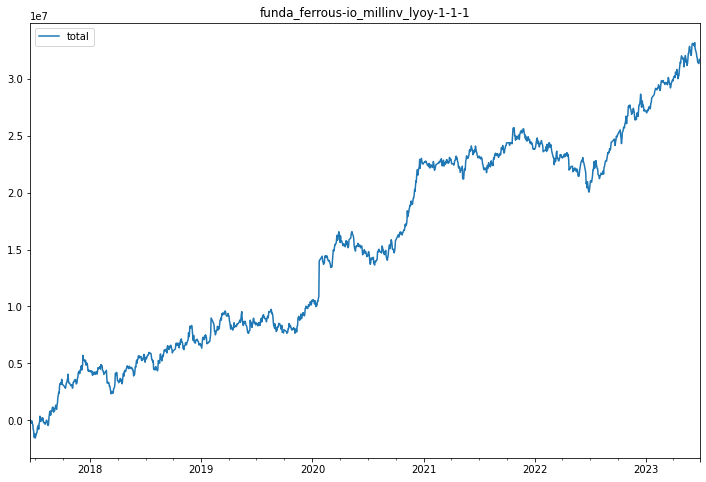

       sharpe        std  sortino
tenor                            
all      1.28  264073.57     2.10
6m       2.41  244910.58     3.96
1y       2.71  266251.94     4.18
2y       1.04  258903.33     1.54
3y       1.39  259488.56     2.06
4y       1.37  271380.06     2.24
5y       1.24  268856.33     2.05
6y       1.31  264343.52     2.16
7y       1.28  264073.57     2.10
8y       1.28  264073.57     2.10
9y       1.28  264073.57     2.10
10y      1.28  264073.57     2.10
11y      1.28  264073.57     2.10


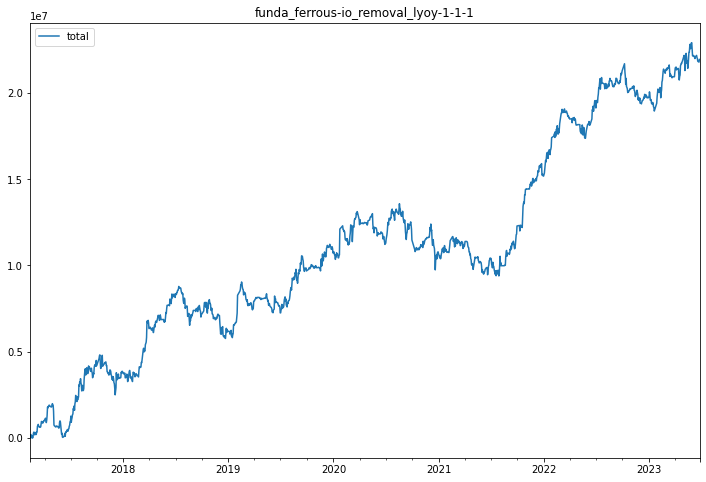

       sharpe        std  sortino
tenor                            
all      1.13  196203.45     1.63
6m       1.36  213845.49     1.78
1y       0.86  197082.70     1.14
2y       1.91  196949.96     2.69
3y       1.12  196945.29     1.56
4y       1.16  198571.04     1.66
5y       0.89  196358.32     1.29
6y       1.15  198178.54     1.70
7y       1.13  196203.45     1.63
8y       1.13  196203.45     1.63
9y       1.13  196203.45     1.63
10y      1.13  196203.45     1.63
11y      1.13  196203.45     1.63


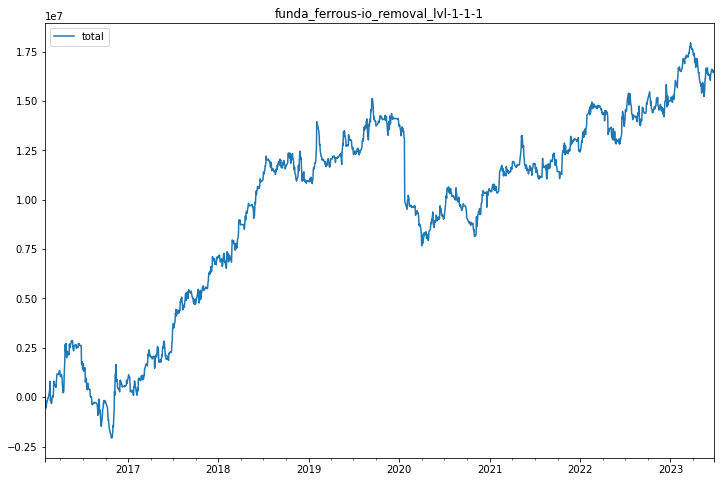

       sharpe        std  sortino
tenor                            
all      0.67  215710.82     0.82
6m       1.11  179899.99     1.70
1y       0.80  201003.51     1.12
2y       0.74  204471.53     1.01
3y       0.79  196963.66     1.11
4y       0.28  219895.73     0.32
5y       0.33  216742.74     0.39
6y       0.69  212177.18     0.85
7y       0.64  213678.12     0.79
8y       0.67  215710.82     0.82
9y       0.67  215710.82     0.82
10y      0.67  215710.82     0.82
11y      0.67  215710.82     0.82


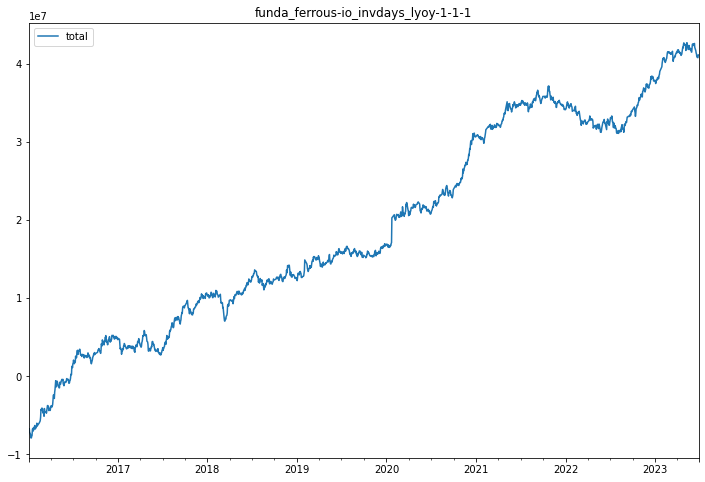

       sharpe        std  sortino
tenor                            
all      1.17  273729.39     1.88
6m       1.74  249825.71     2.53
1y       2.13  260043.36     3.42
2y       0.76  261741.59     1.22
3y       1.63  260860.05     2.56
4y       1.48  273267.12     2.52
5y       1.39  269467.03     2.33
6y       1.53  266444.29     2.58
7y       1.37  266802.35     2.28
8y       1.30  273850.80     2.09
9y       1.17  273729.39     1.88
10y      1.17  273729.39     1.88
11y      1.17  273729.39     1.88


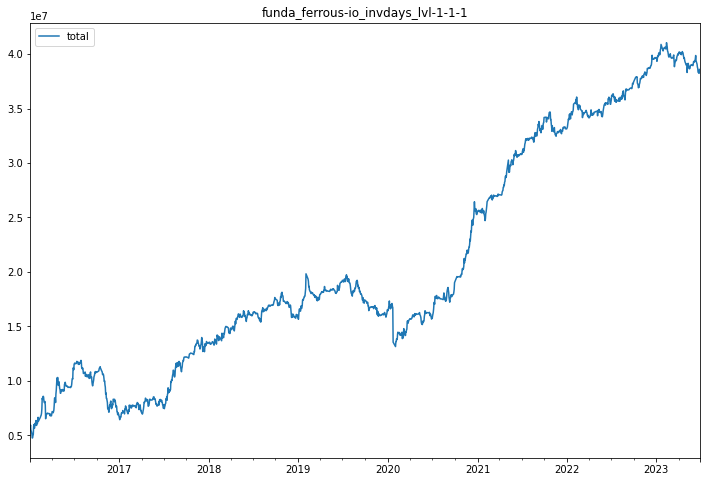

       sharpe        std  sortino
tenor                            
all      1.21  221014.99     1.53
6m      -0.72  205743.28    -0.91
1y       0.93  195537.30     1.25
2y       1.21  204946.30     1.67
3y       2.22  215911.33     3.16
4y       1.34  233683.09     1.51
5y       1.29  225220.61     1.51
6y       1.48  222670.23     1.80
7y       1.14  220266.71     1.41
8y       1.33  225378.28     1.68
9y       1.24  222225.70     1.57
10y      1.21  221014.99     1.53
11y      1.21  221014.99     1.53


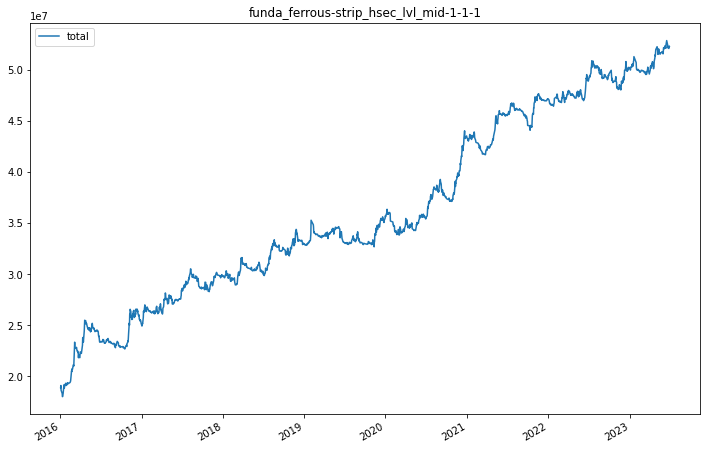

       sharpe        std  sortino
tenor                            
all      1.37  196241.54     2.01
6m       1.35  198469.28     1.92
1y       0.96  213566.93     1.32
2y       1.04  205725.64     1.55
3y       1.68  212183.94     2.70
4y       1.48  208116.89     2.30
5y       1.36  209458.89     2.08
6y       1.28  204792.28     1.96
7y       1.29  205445.97     2.00
8y       1.51  219988.27     2.33
9y       1.42  216494.86     2.12
10y      1.49  213303.63     2.24
11y      1.42  206250.84     2.12


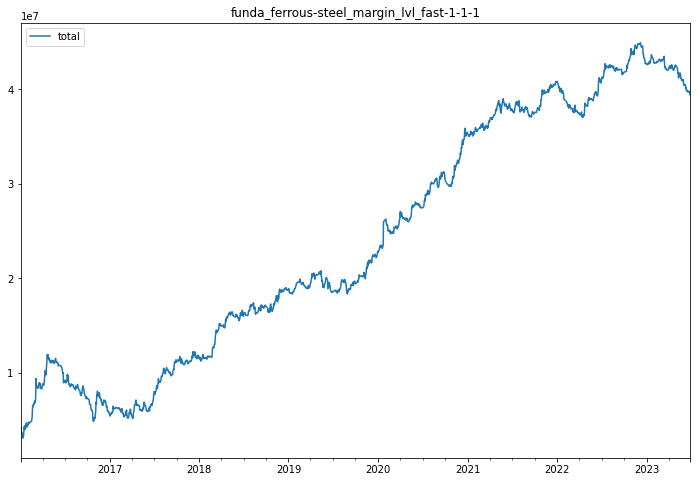

       sharpe        std  sortino
tenor                            
all      1.30  235981.24     1.97
6m      -2.41  178493.19    -2.64
1y      -0.47  194155.24    -0.57
2y       0.27  204632.55     0.38
3y       1.20  212431.56     1.80
4y       1.52  220939.17     2.47
5y       1.35  218063.21     2.09
6y       1.62  214809.26     2.55
7y       1.29  217192.46     2.01
8y       1.32  236498.12     1.99
9y       1.30  235981.24     1.97
10y      1.30  235981.24     1.97
11y      1.30  235981.24     1.97


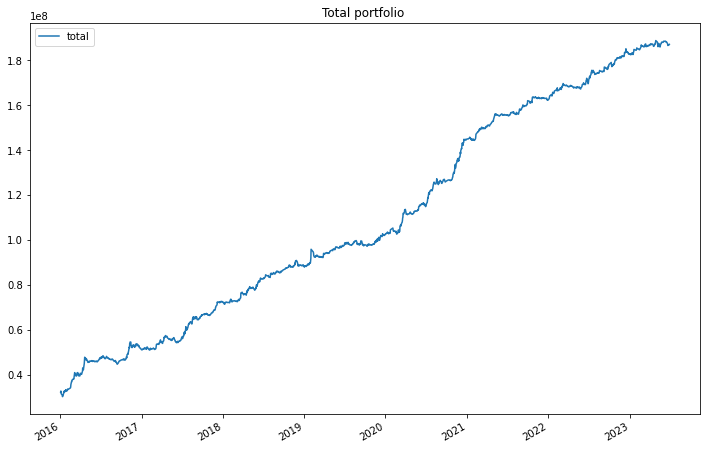

       sharpe        std  sortino
tenor                            
all      2.65  363252.63     4.05
6m       1.42  397980.99     1.67
1y       2.54  422209.26     3.56
2y       2.52  400415.67     3.59
3y       3.40  447129.94     5.31
4y       3.25  442466.78     5.18
5y       3.08  436400.14     5.05
6y       3.21  437399.17     5.31
7y       2.96  432858.19     4.87
8y       2.99  439467.24     4.90
9y       2.88  420718.69     4.65
10y      2.85  402129.94     4.53
11y      2.79  385580.86     4.37
pnl per trade: product
rb     61.598078
hc     94.838023
i     163.363878
j      96.638017
jm     83.284420
ru     25.520165
FG     81.539244
cu     11.161830
al     22.240238
zn      9.878398
sn     40.692786
l      17.389736
pp     38.806489
v      56.906379
TA     55.132499
sc    126.683107
m      16.768968
RM      9.259381
y      42.826831
p      53.225064
OI     33.757537
a       2.095385
c       1.943875
CF      4.218597
jd     21.833129
AP     96.267443
SM     32.955386
eb    15

In [10]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = tday

scenario_map = {
    'test': scenarios_test,
    'test2': scenarios_test2,
    'elite': scenarios_elite,
}

shift_mode = 2
rev_char = '!'
exec_mode = 'open'
total_risk = 350_000.0
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'test2'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2016-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
        elif signal_name == 'leader_lagger':
            run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'UR', 'sc',
                                        'al', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI',]
            run_args['conv_func'] = 'qtl'
            run_args['signal_func'] = leader_lagger
    elif sim_type == 'funda_ferrous':
        run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'FG', 'v']
        run_args['signal_func'] = custom_funda_signal
        run_args['funda_data'] = spot_df
        run_args['signal_cap'] = params
        run_args['signal_name'] = signal_name        
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


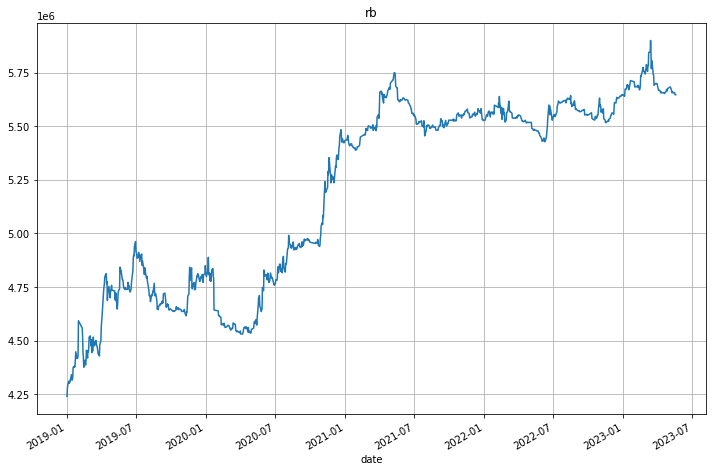

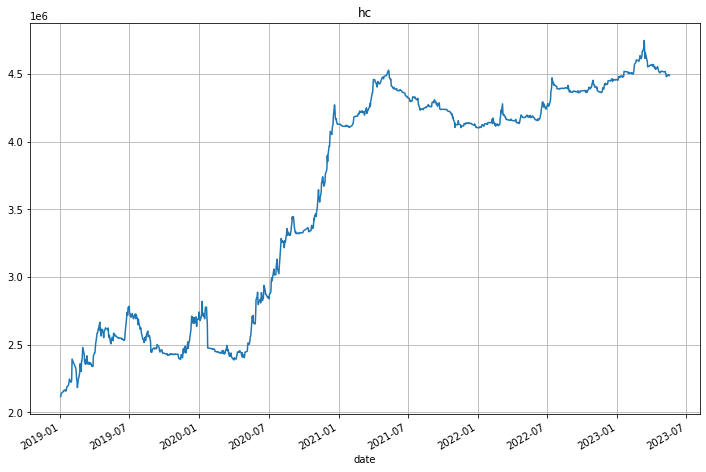

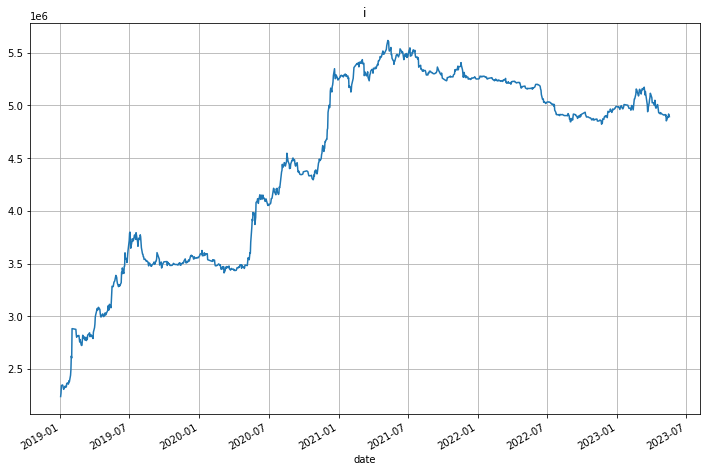

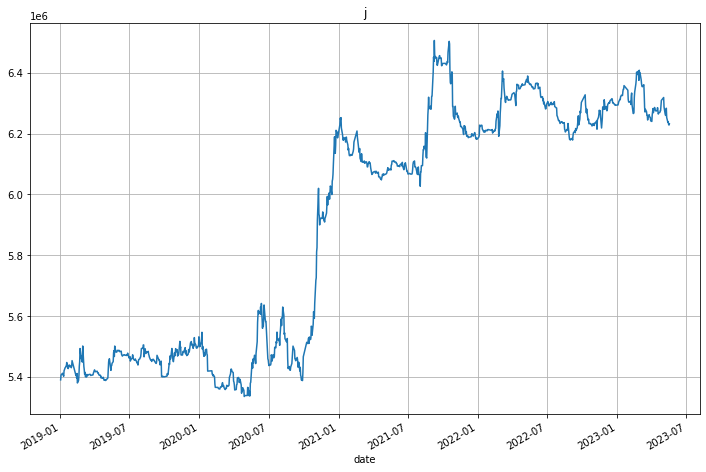

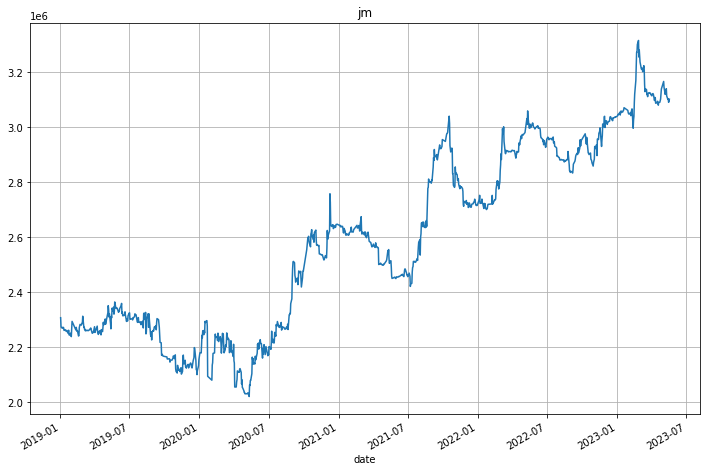

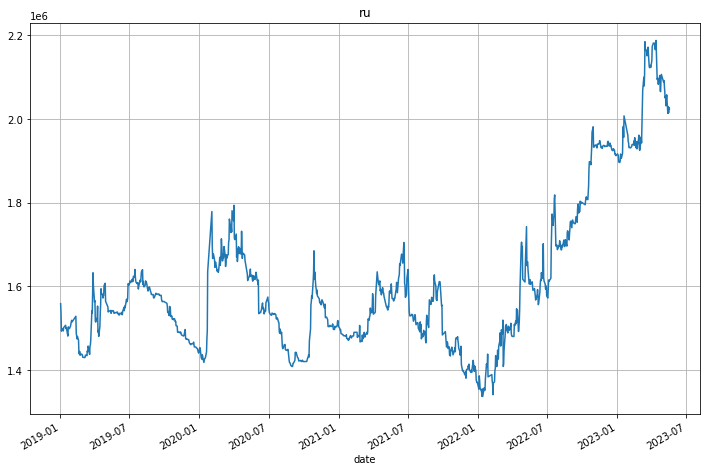

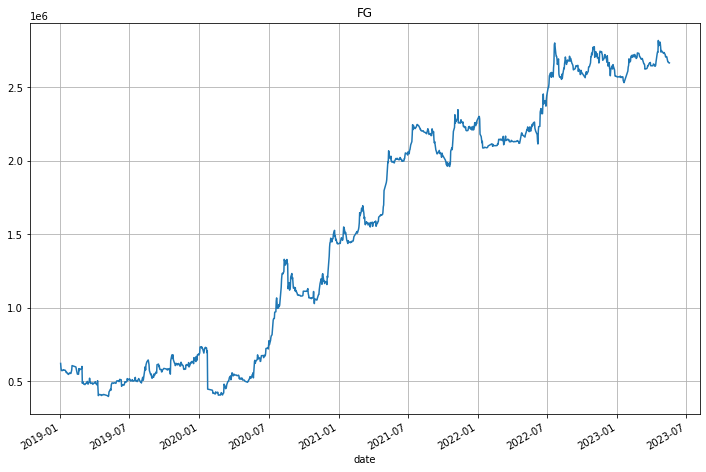

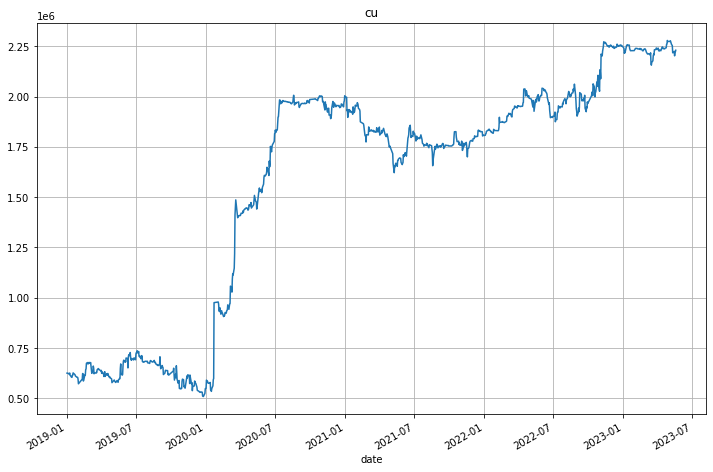

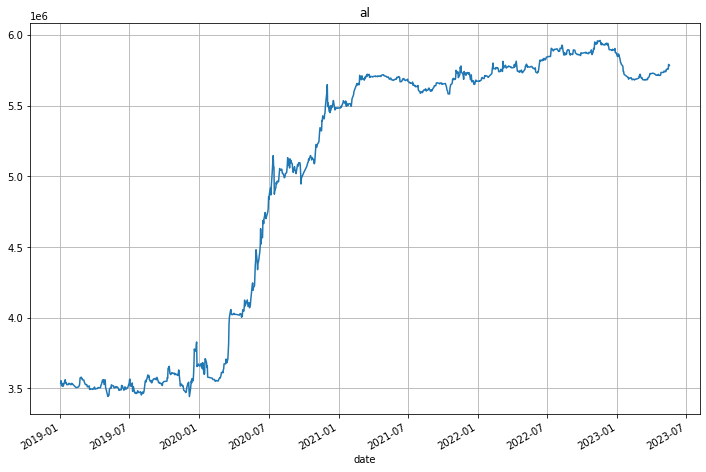

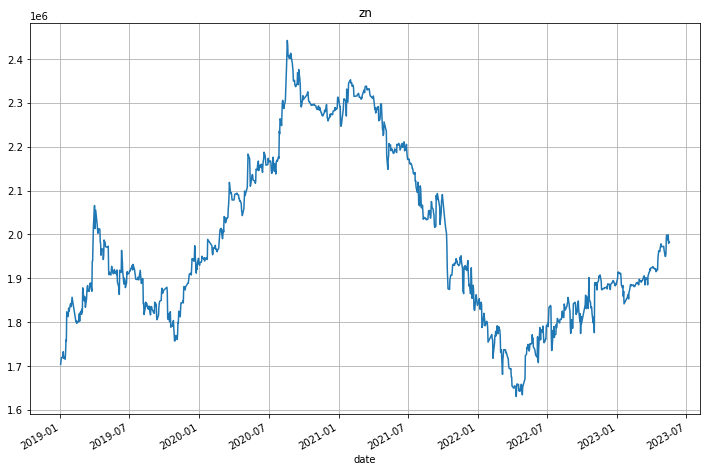

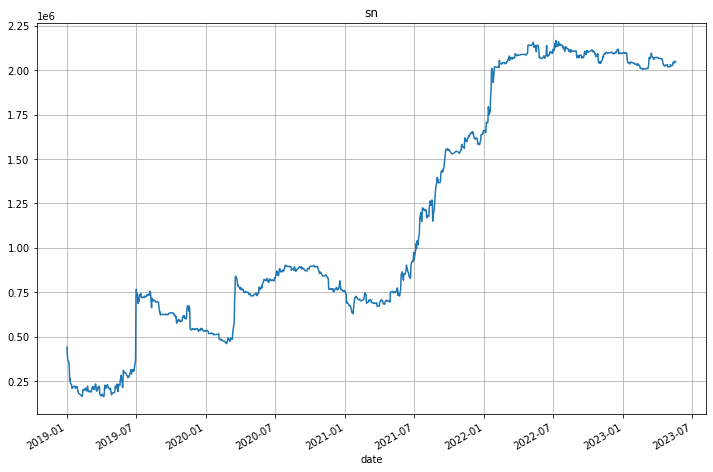

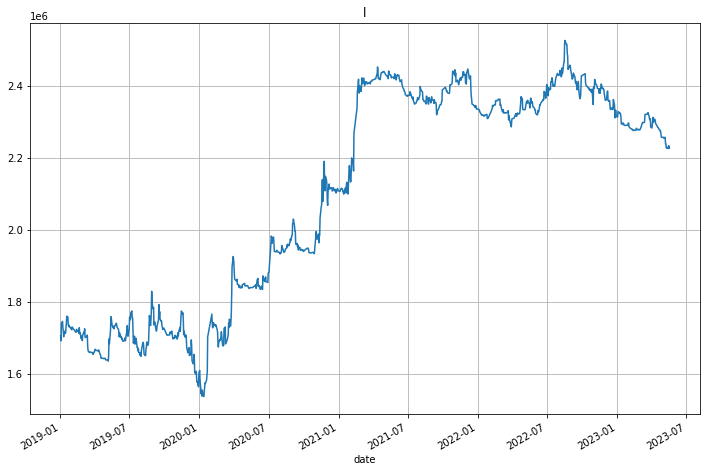

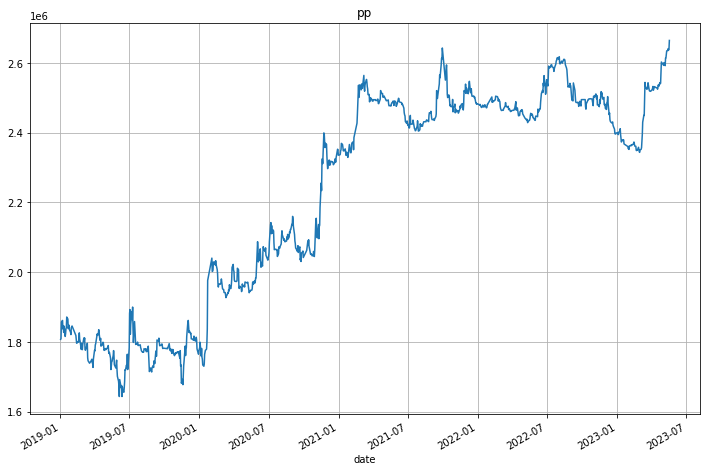

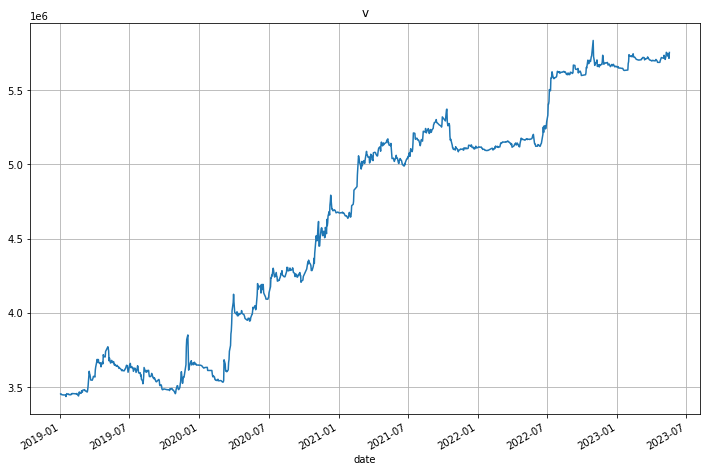

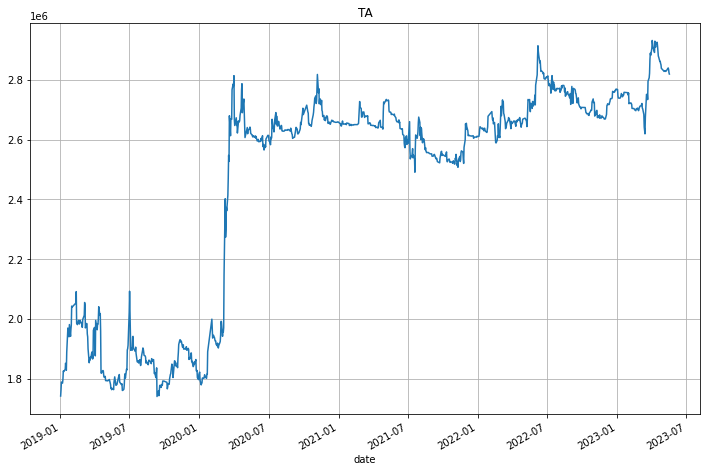

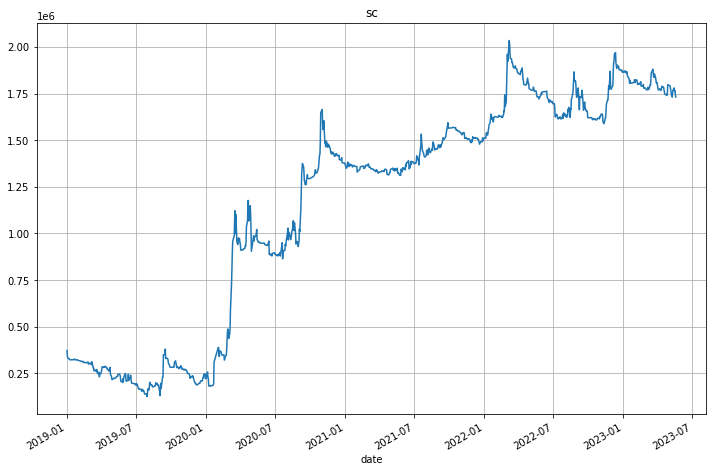

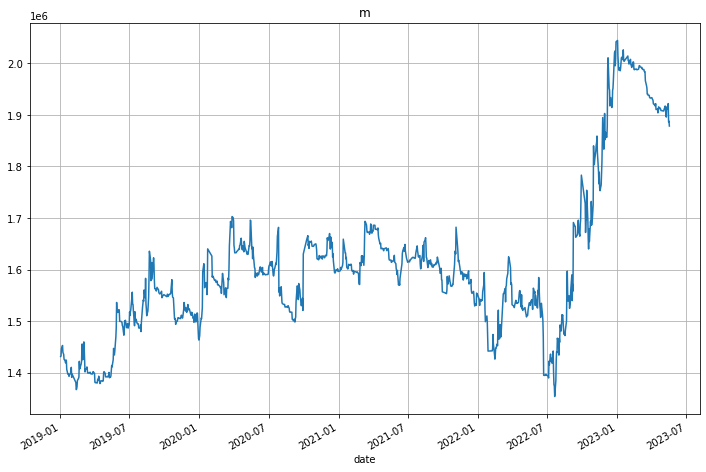

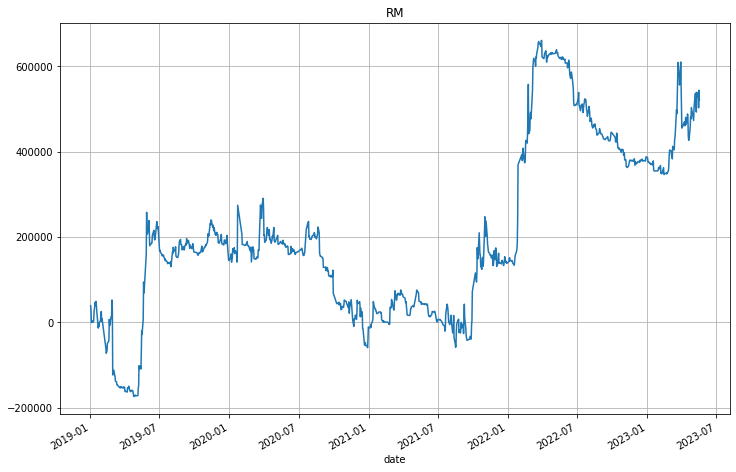

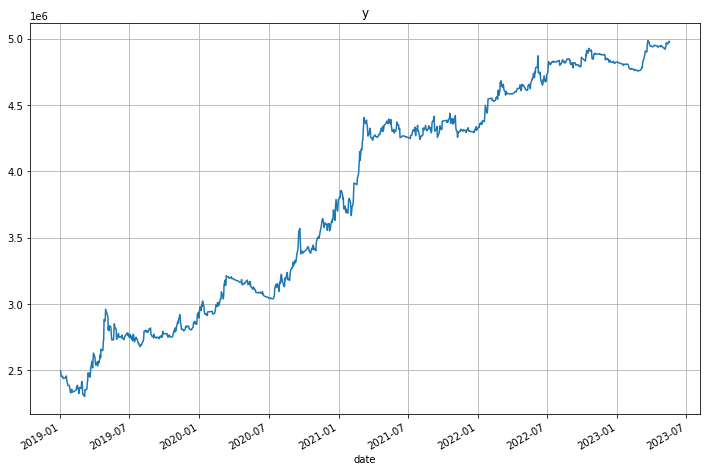

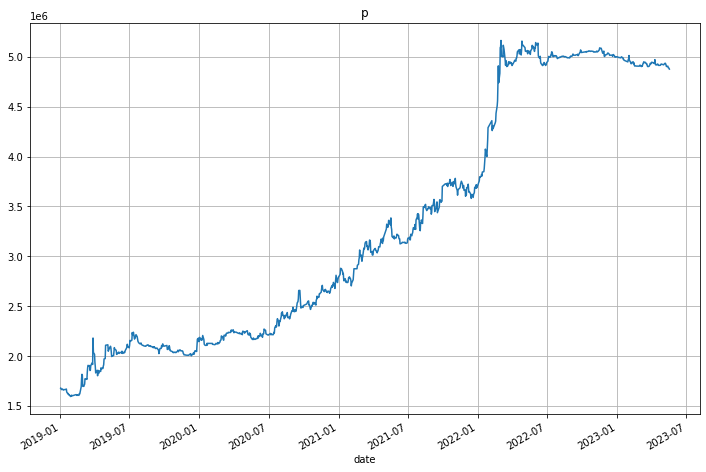

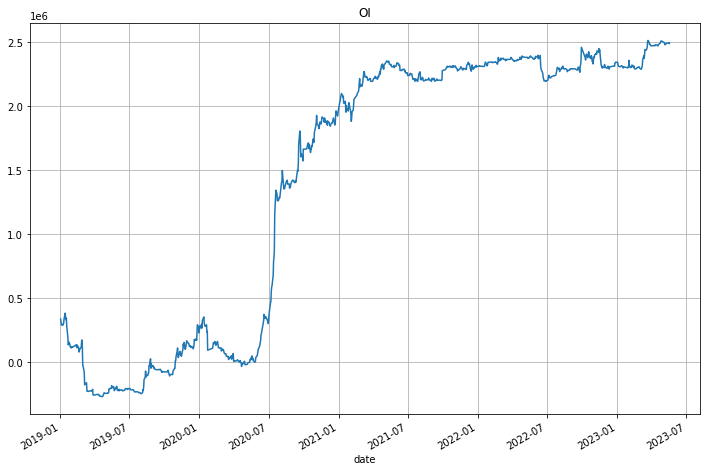

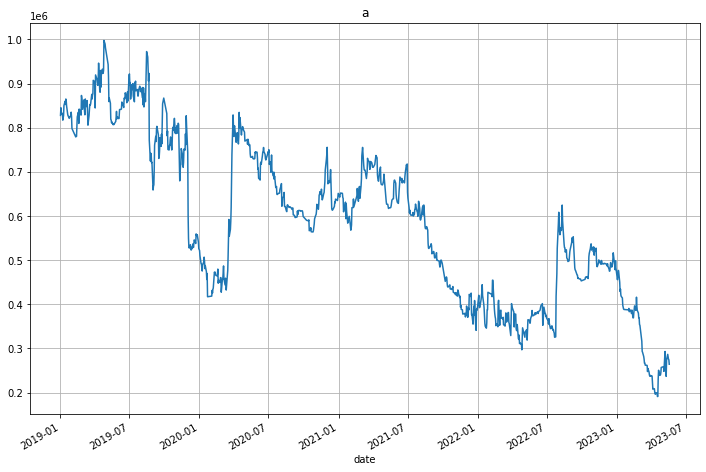

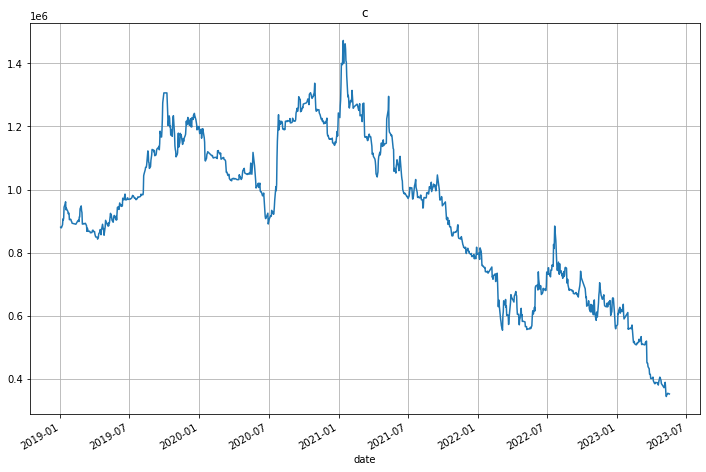

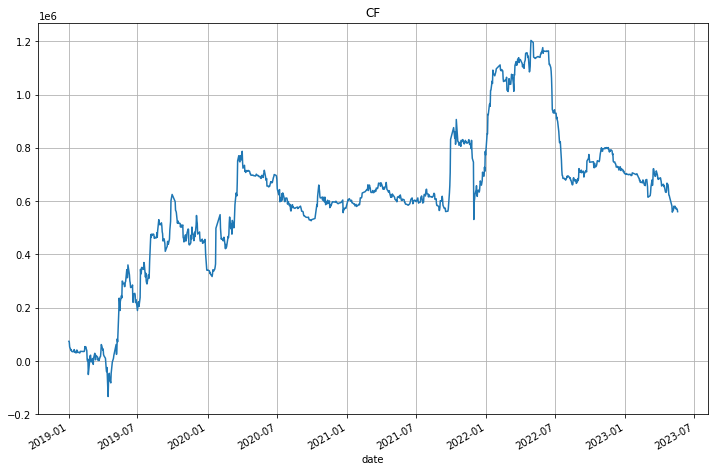

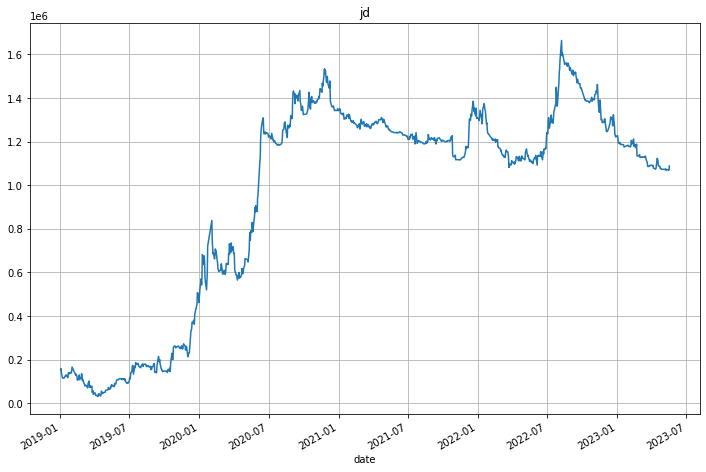

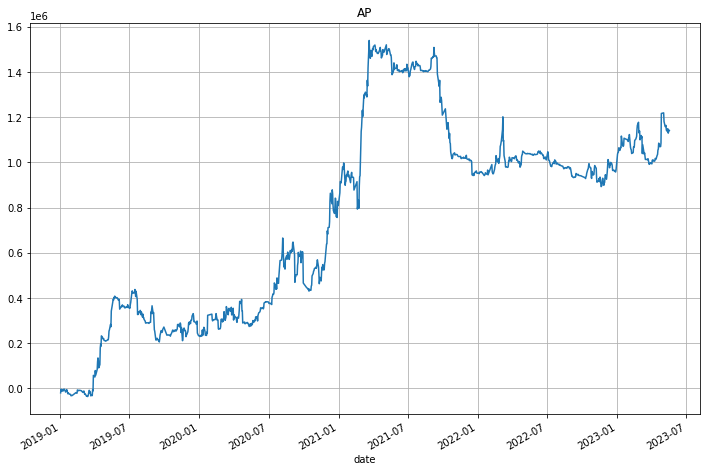

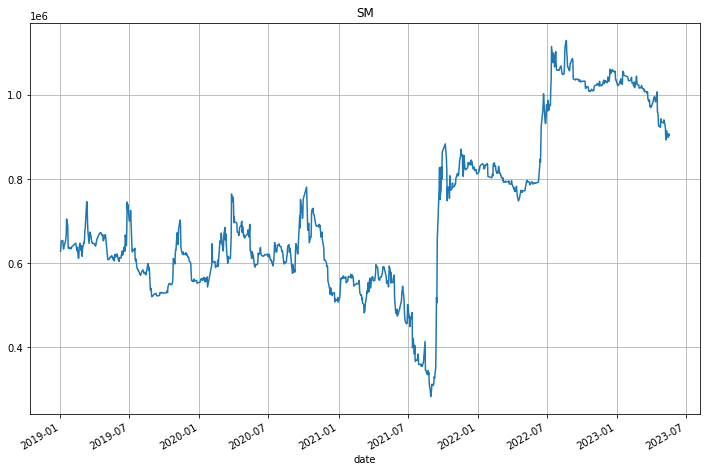

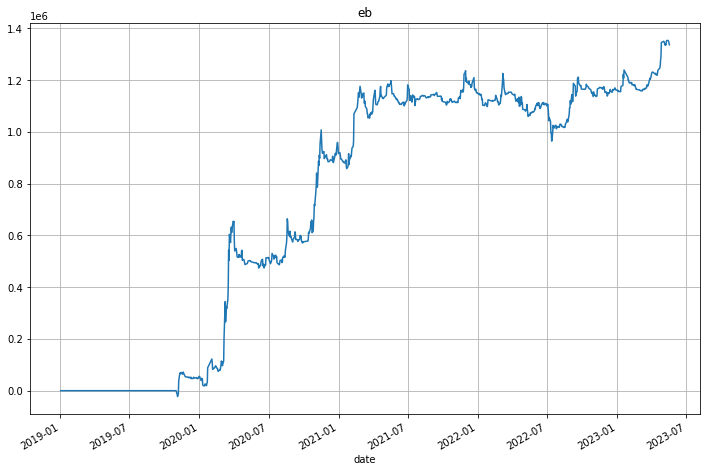

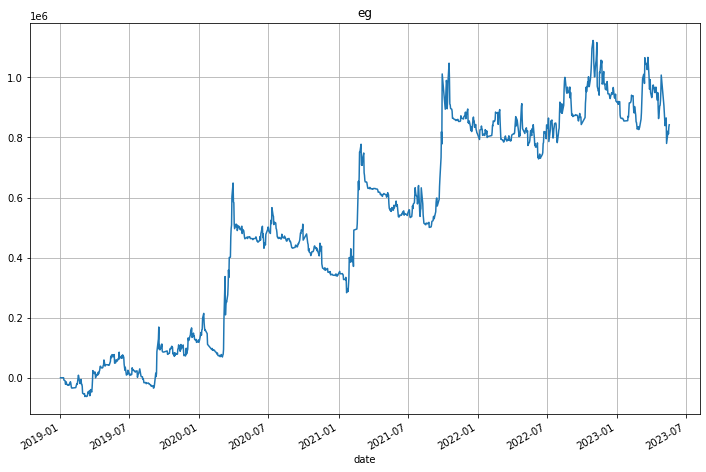

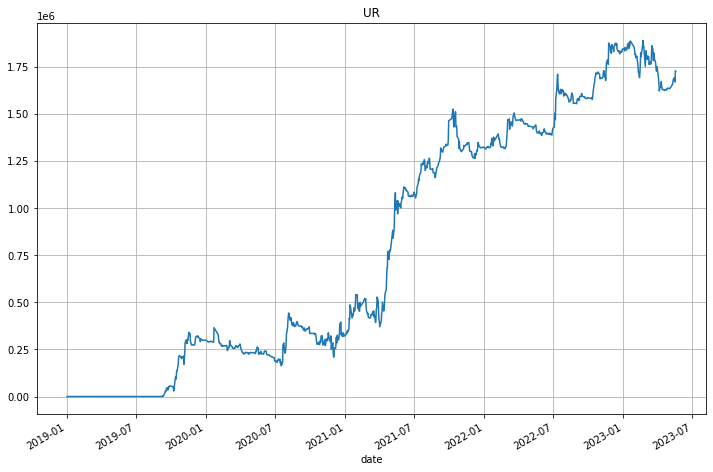

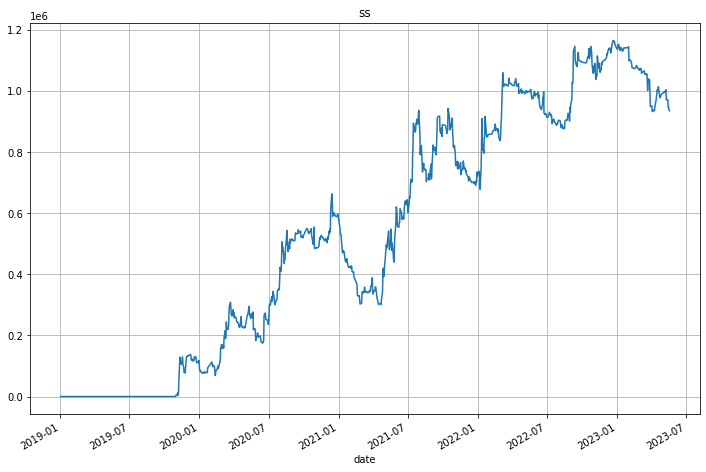

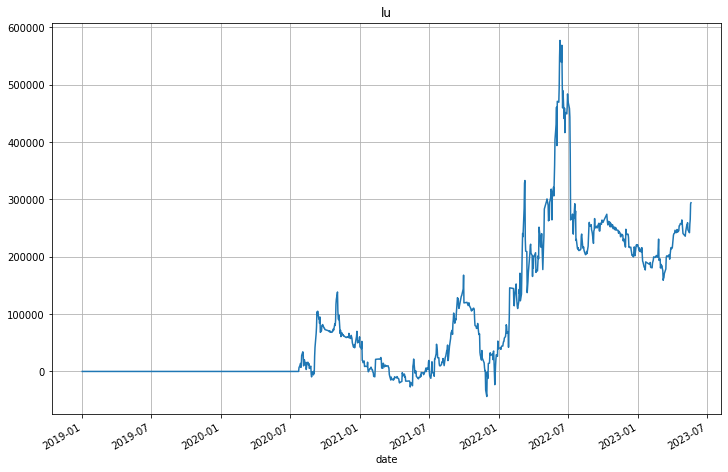

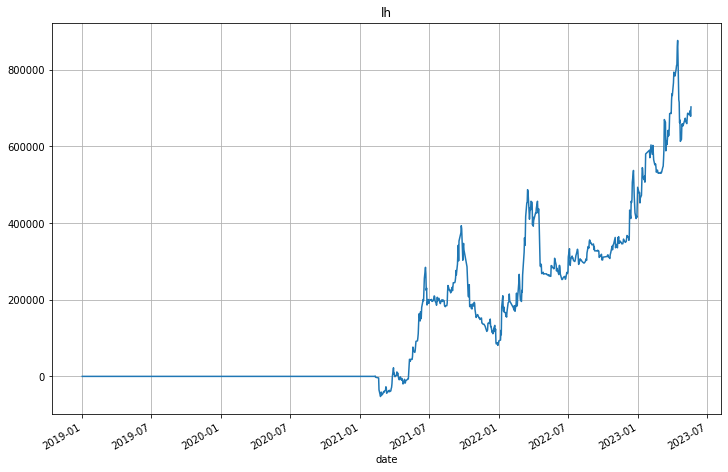

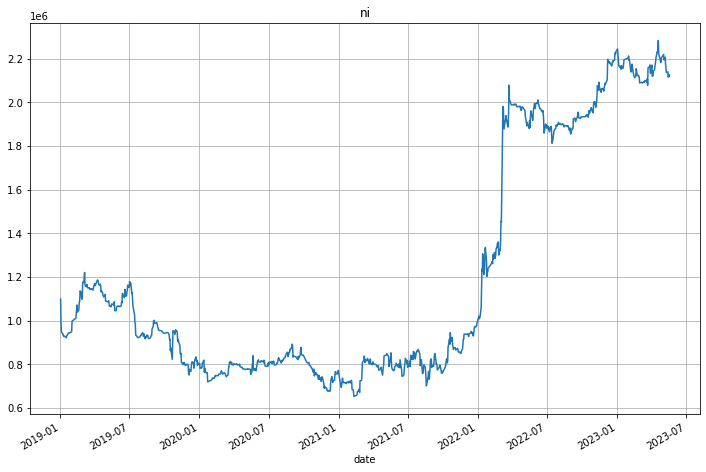

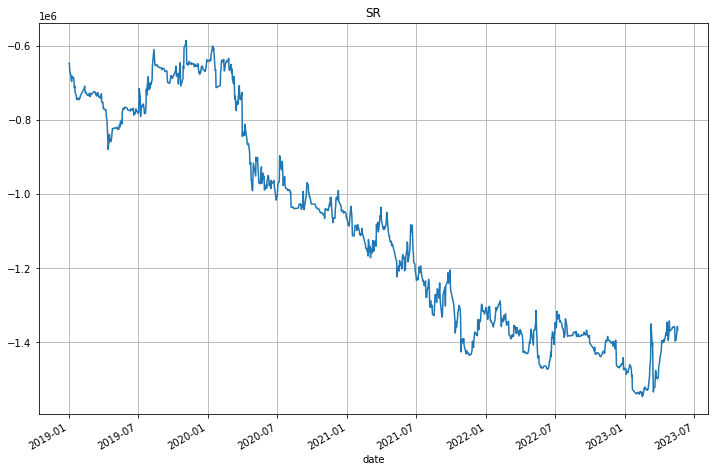

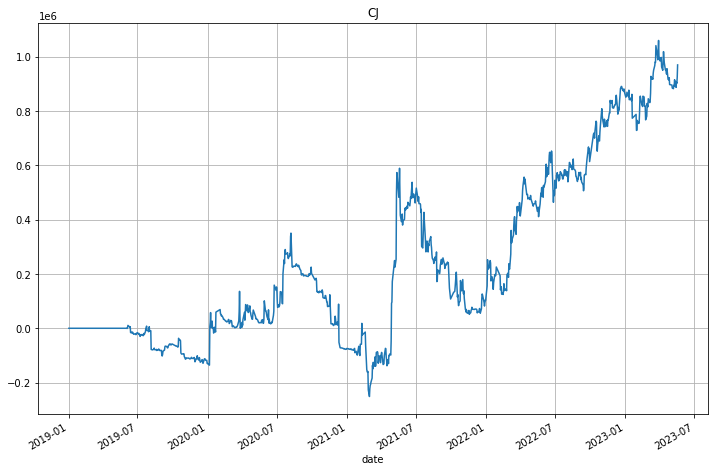

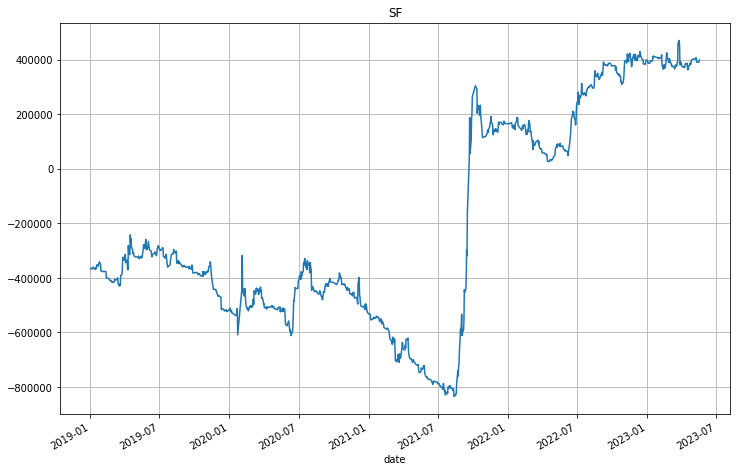

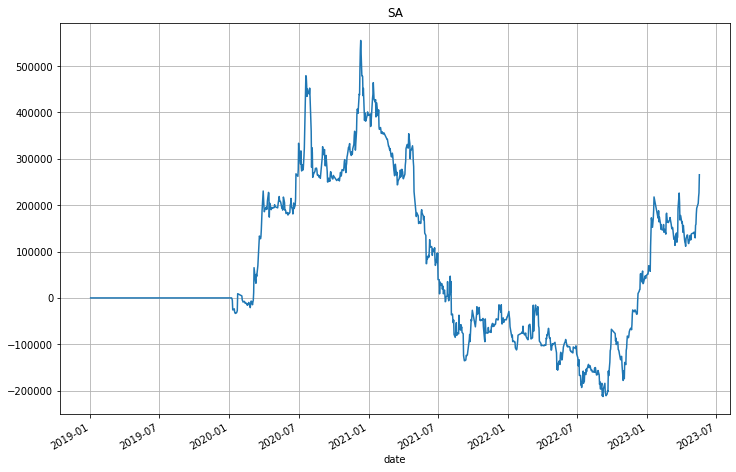

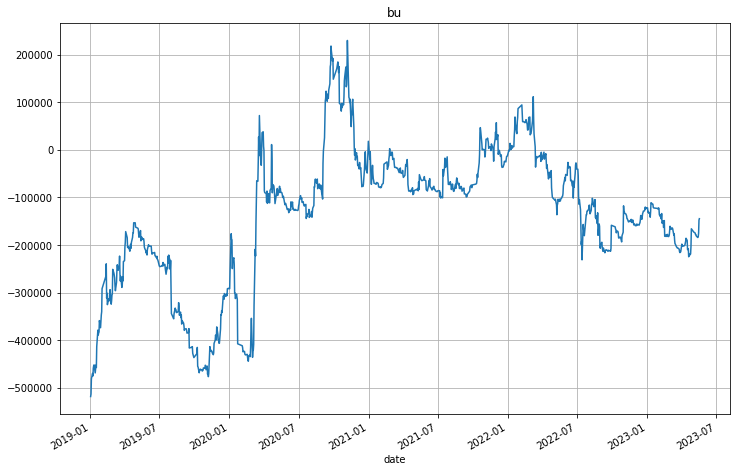

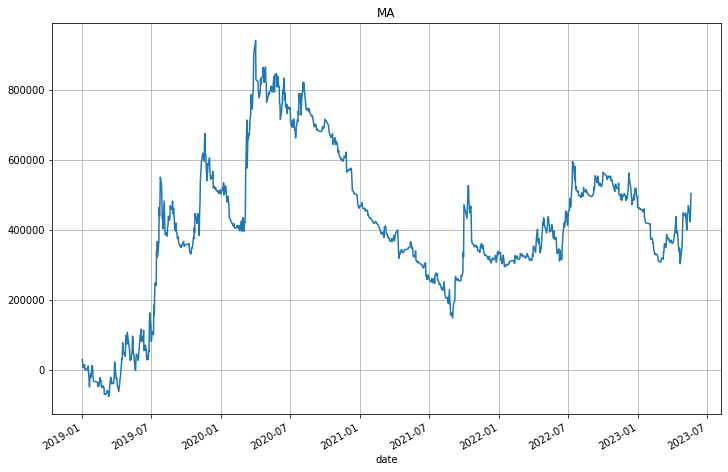

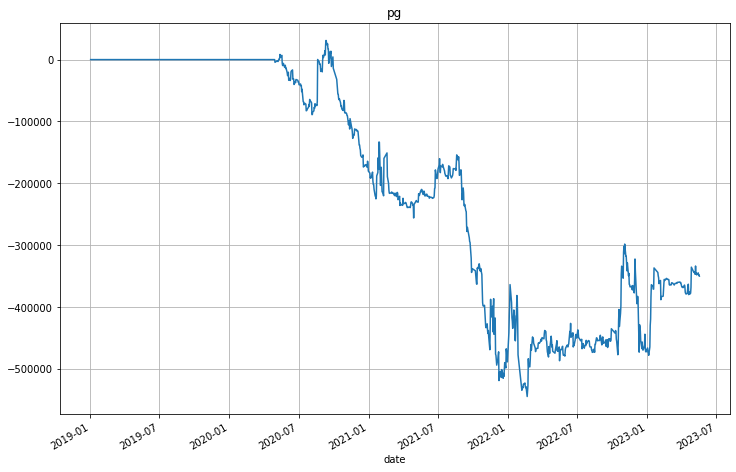

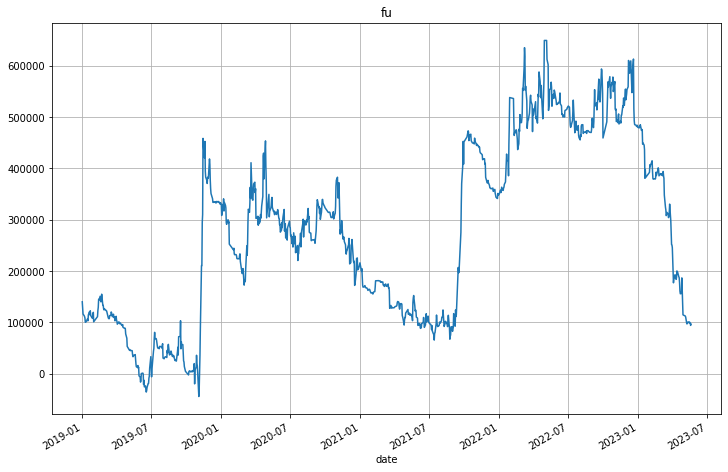

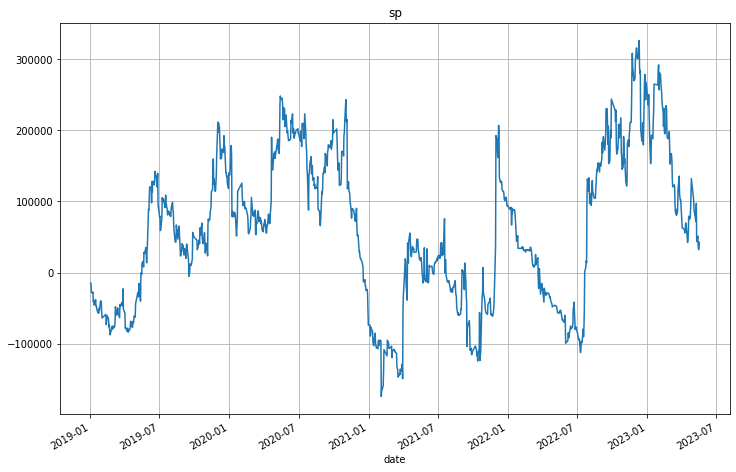

In [12]:
#pnl_stats = bt_empirics[run_key].calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

#pnl_stats['asset_sharpe_stats']

for asset in port_stats['asset_cumpnl'].columns:
    port_stats['asset_cumpnl'][asset]['2019-01-01':].plot(title=asset)
    plt.grid()
    plt.show()